In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import scipy.io as sio
import random
import matplotlib.patches as patches
from PIL import Image
from scipy.io import loadmat
import tensorflow as tf
import cv2
import tarfile
import cv2 as cv
import shutil

In [2]:
base_dir1 = '/kaggle/input/cars-devkit'
annotations = sio.loadmat(os.path.join(base_dir1, 'cars_train_annos.mat'))

In [3]:
cars_meta = loadmat('/kaggle/input/cars-devkit/cars_meta.mat')

cars_train_annos = loadmat('/kaggle/input/cars-devkit/cars_train_annos.mat')
train_annotations = cars_train_annos['annotations'][0]

cars_test_annos = loadmat('/kaggle/input/cars-devkit/cars_test_annos_withlabels.mat')
test_annotations = cars_test_annos['annotations'][0]

class_names = cars_meta['class_names'][0]
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 196


In [4]:
print(train_annotations)

[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9'))
 (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9'))
 (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9'))
 ...
 (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9'))
 (array([[78]], dtype=uint8), array([[526]], dtype=uint16), array([[1489]], dtype=uint16), array([[908]], dtype=uint16), array([[112]], dtype=uint8), array(['08143.jpg'], dtype='<U9'))
 (array([[20]], dtype=uint8), array([[240]], dtype=uint8), array([[862]], dtype=ui

In [5]:
train_image_paths = [ann['fname'][0] for ann in train_annotations]  # Remove nested array structure
train_class_indices = [ann['class'][0][0] - 1 for ann in train_annotations]  # Extract class index
test_image_paths = [ann['fname'][0] for ann in test_annotations]
test_class_indices = [ann['class'][0][0] - 1 for ann in test_annotations]

In [6]:
!rm -rf /kaggle/working/*

In [7]:
def save_data(annotations, type='train'):
    for ann in annotations:
        class_name = class_names[ann['class'][0][0] - 1]
        image_path = ann['fname'][0]
        x1 = ann['bbox_x1'][0][0]
        x2 = ann['bbox_x2'][0][0]
        y1 = ann['bbox_y1'][0][0]
        y2 = ann['bbox_y2'][0][0]
        if type == 'train':
            base_dir = '/kaggle/input/stanford-cars-dataset/cars_train/cars_train'
        else:
            base_dir = '/kaggle/input/stanford-cars-dataset/cars_test/cars_test'
            
        image_path = os.path.join(base_dir, image_path)
        image = cv.imread(image_path)
        height, width = image.shape[:2]
        margin = 16
    
        x1 = max(0, ann['bbox_x1'][0][0] - margin)
        x2 = min(ann['bbox_x2'][0][0] + margin, width)
        y1 = max(0, ann['bbox_y1'][0][0] - margin)
        y2 = min(ann['bbox_y2'][0][0] + margin, height)
    
        if type == 'train':
            dest_folder = '/kaggle/working/train/'
        else:
            dest_folder = '/kaggle/working/test/'
        dest_path = os.path.join(dest_folder, class_name[0])
        if not os.path.exists(dest_path):
            os.makedirs(dest_path)
        dest_path = os.path.join(dest_path, ann['fname'][0])
        crop_image = image[y1:y2, x1:x2]
        dest_img = cv.resize(src=crop_image, dsize=(224, 224))
        cv.imwrite(dest_path, dest_img)

save_data(train_annotations, type='train')
save_data(test_annotations, type='test')

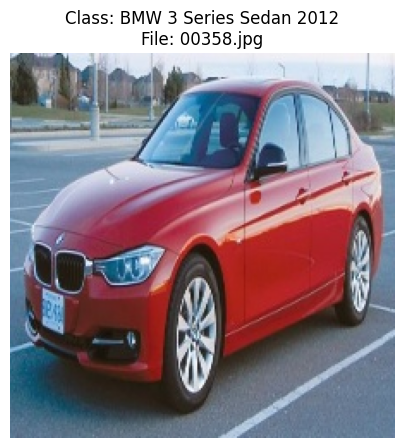

In [8]:
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random

def show_processed_sample(dataset_type='train'):
    """Displays a random processed image along with its class label from the given dataset type ('train', 'validation', 'test')."""
    
    base_folder = f'/kaggle/working/{dataset_type}/'  # Folder where images are saved
    class_folders = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]

    if not class_folders:
        print(f"No images found in {base_folder}")
        return
    
    # Choose a random class folder
    random_class = random.choice(class_folders)
    class_folder = os.path.join(base_folder, random_class)

    # Choose a random image from the selected class folder
    image_files = os.listdir(class_folder)
    if not image_files:
        print(f"No images found in {class_folder}")
        return

    random_image = random.choice(image_files)
    image_path = os.path.join(class_folder, random_image)

    # Load and display the image
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Class: {random_class}\nFile: {random_image}")  # Show class label in title
    plt.axis("off")
    plt.show()

# Call function to show a sample from the training dataset
show_processed_sample('train')

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten #action detectionimport tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications, regularizers

# Define directories
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"

# Image Parameters
img_size = (224, 224)
batch_size = 32

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=applications.efficientnet.preprocess_input,  # EfficientNet preprocessing
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=applications.efficientnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load Pre-trained Model (MobileNetV2)
base_model = applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,  # Remove classification head
    weights="imagenet"  # Use pre-trained weights
)

# Freeze base model layers
base_model.trainable = False  

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Increased neurons
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile Model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)




Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Fine-tune model
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15  # Train with fine-tuning
)

Epoch 1/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 123s 483ms/step - accuracy: 0.0328 - loss: 21.1107 - val_accuracy: 0.1546 - val_loss: 12.5142
Epoch 2/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 80s 378ms/step - accuracy: 0.1202 - loss: 11.4406 - val_accuracy: 0.2038 - val_loss: 8.1354
Epoch 3/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 82s 379ms/step - accuracy: 0.1751 - loss: 8.0037 - val_accuracy: 0.2658 - val_loss: 6.3991
Epoch 4/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 80s 378ms/step - accuracy: 0.2053 - loss: 6.5704 - val_accuracy: 0.2477 - val_loss: 5.8860
Epoch 5/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 380ms/step - accuracy: 0.2134 - loss: 6.0756 - val_accuracy: 0.2736 - val_loss: 5.4676
Epoch 6/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 379ms/step - accuracy: 0.2466 - loss: 5.6003 - val_accuracy: 0.2658 - val_loss: 5.2233
Epoch 7/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 382ms/step - accuracy: 0.2380 - loss: 5.4706 - val_accuracy: 0.3098 - val_loss: 4.9265
Epoch 8/15
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 379ms/step - accuracy: 0.2560 - los

In [16]:
# Fine-tuning: Unfreeze some EfficientNetB0 layers
base_model.trainable = True  # Unfreeze entire model

# Freeze first few layers
for layer in base_model.layers[:100]:  
    layer.trainable = False  

# Compile with lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [17]:
# Train Again
model.fit(train_generator, validation_data=val_generator, epochs=35)

Epoch 1/35
207/207 ━━━━━━━━━━━━━━━━━━━━ 162s 542ms/step - accuracy: 0.1870 - loss: 5.4646 - val_accuracy: 0.4386 - val_loss: 3.7243
Epoch 2/35
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 382ms/step - accuracy: 0.3754 - loss: 3.9852 - val_accuracy: 0.5298 - val_loss: 3.3067
Epoch 3/35
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 382ms/step - accuracy: 0.4674 - loss: 3.4830 - val_accuracy: 0.5847 - val_loss: 3.0166
Epoch 4/35
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 381ms/step - accuracy: 0.5506 - loss: 3.1285 - val_accuracy: 0.6404 - val_loss: 2.7476
Epoch 5/35
207/207 ━━━━━━━━━━━━━━━━━━━━ 82s 385ms/step - accuracy: 0.6049 - loss: 2.8134 - val_accuracy: 0.6585 - val_loss: 2.5619
Epoch 6/35
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 382ms/step - accuracy: 0.6368 - loss: 2.6046 - val_accuracy: 0.6863 - val_loss: 2.3974
Epoch 7/35
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 383ms/step - accuracy: 0.6772 - loss: 2.3758 - val_accuracy: 0.6992 - val_loss: 2.2663
Epoch 8/35
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 379ms/step - accuracy: 0.6987 - loss: 

In [21]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

252/252 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.8412 - loss: 0.8862
Test Accuracy: 0.8530


In [22]:
# Save the model
model.save("transfer_learning_efficientnet_car_classification_model.h5")